In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np 
import pandas as pd 
import os
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import os
from PIL import Image, ImageFile
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", Image.DecompressionBombWarning)

In [2]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import os
from PIL import Image, ImageFile
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", Image.DecompressionBombWarning)



# Define dataset path
data_dir = '/kaggle/input/ai-generated-images-vs-real-images/train'



Image.MAX_IMAGE_PIXELS = None  
# or
Image.MAX_IMAGE_PIXELS = 200000000  


def convert_to_rgb(image):
    if image.mode == 'P':  
        image = image.convert("RGBA")  
    if image.mode == "RGBA":  
        background = Image.new("RGB", image.size, (255, 255, 255))
        image = Image.alpha_composite(background, image).convert("RGB")
    elif image.mode != "RGB":
        image = image.convert("RGB") 
    return image



def resize_large_image(image, max_size):
    if image.size[0] > max_size[0] or image.size[1] > max_size[1]:
        image.thumbnail(max_size, Image.Resampling.LANCZOS)  
    return image


train_transform = transforms.Compose([
    transforms.Lambda(lambda img: resize_large_image(img, max_size=(5000, 5000))),  
    transforms.Lambda(convert_to_rgb),               
    transforms.RandomResizedCrop(224),               
    transforms.RandomHorizontalFlip(p=0.5),          
    transforms.RandomVerticalFlip(p=0.2),            
    transforms.RandomRotation(degrees=15),           
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  
    transforms.ToTensor(),                           # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
])



val_transform = transforms.Compose([
    transforms.Lambda(convert_to_rgb),  
    transforms.Resize((224, 224)),      
    transforms.ToTensor(),             
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
])


ImageFile.LOAD_TRUNCATED_IMAGES = True


MIN_IMAGE_FILE_SIZE = 3284  


def is_valid_image(file_path):
    try:
        if os.path.getsize(file_path) < MIN_IMAGE_FILE_SIZE:
            return False
        
        with Image.open(file_path) as img:
            img.verify()  
        return True
    except (OSError, Image.DecompressionBombError):
        return False


class ValidImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)
        self.samples = [(path, label) for path, label in self.samples if is_valid_image(path)]
        self.targets = [label for _, label in self.samples]


dataset = ValidImageFolder(root=data_dir, transform=train_transform)

In [3]:
from torch.utils.data import Subset

fake_indices = [i for i, (_, label) in enumerate(dataset.samples) if label == dataset.class_to_idx['fake']]
real_indices = [i for i, (_, label) in enumerate(dataset.samples) if label == dataset.class_to_idx['real']]


fake_subset_size = int(1.0/3.0 * len(fake_indices))
real_subset_size = int(1.0/3.0 * len(real_indices))

fake_subset_indices = fake_indices[:fake_subset_size]  
real_subset_indices = real_indices[:real_subset_size]  

balanced_subset_indices = np.concatenate((fake_subset_indices, real_subset_indices))

balanced_subset = Subset(dataset, balanced_subset_indices)

print(f"Original Dataset Size: {len(dataset)}")
print(f"Balanced Subset Size: {len(balanced_subset)} (Fake: {fake_subset_size}, Real: {real_subset_size})")


Original Dataset Size: 47998
Balanced Subset Size: 15999 (Fake: 8000, Real: 7999)


In [4]:
train_size = int(0.8 * len(balanced_subset))
val_size = len(balanced_subset) - train_size
train_dataset, val_dataset = random_split(balanced_subset, [train_size, val_size])

val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [5]:
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")

Train Dataset Size: 12799
Validation Dataset Size: 3200


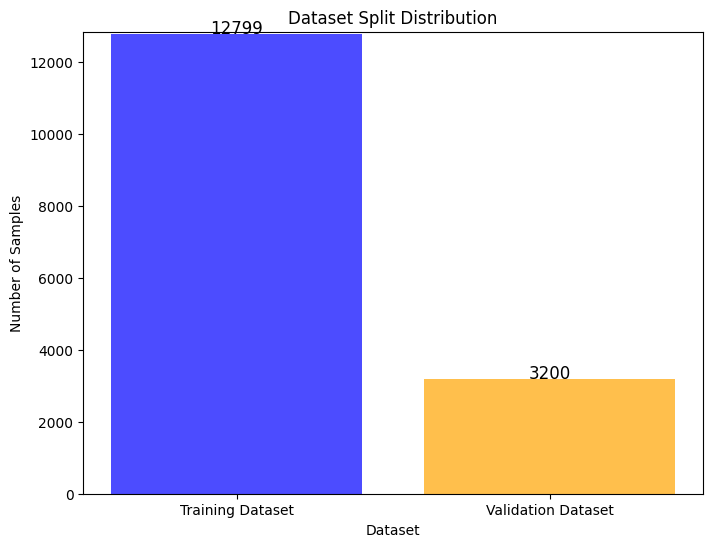

In [6]:
import matplotlib.pyplot as plt

train_size = len(train_dataset)
val_size = len(val_dataset)

labels = ['Training Dataset', 'Validation Dataset']
sizes = [train_size, val_size]

plt.figure(figsize=(8, 6))
plt.bar(labels, sizes, color=['blue', 'orange'], alpha=0.7)

for i, size in enumerate(sizes):
    plt.text(i, size + 5, str(size), ha='center', fontsize=12)

plt.title('Dataset Split Distribution')
plt.ylabel('Number of Samples')
plt.xlabel('Dataset')
plt.ylim(0, max(sizes) + 50)
plt.show()

In [7]:
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load the model state
model.load_state_dict(torch.load('/kaggle/input/mobile-net-model-trained13/pytorch/default/1/best_model6for_mobilnet_sdk_First_training_part.pth', map_location=device))


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 81.0MB/s]
<ipython-input-7-6928d2bdda7a>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of th

<All keys matched successfully>

In [8]:
from torch.optim.lr_scheduler import StepLR

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [9]:
patience = 6
trigger_times = 0
best_val_loss = float('inf')

In [10]:
epochs = 8
best_val_acc = 0.0

# data={
#     "train_losses" : [],
#     "train_accuracies" : [],
#     "val_losses" : [],
#     "val_accuracies" : [],
# }

In [11]:
df = pd.read_csv("/kaggle/input/score-of-mobilenet-aftertrained-in-13-data/scorse2_MobileNet.csv")

data = df.to_dict(orient="list")

print(data)

{'train_losses': [0.3579643191045705, 0.2871724981932502, 0.261627867957588, 0.2131132036447525, 0.1864492709687542, 0.1655151784118474, 0.1647572221956417, 0.1615731157900924], 'train_accuracies': [0.8484256582545512, 0.8794437065395734, 0.8951480584420658, 0.913665130088288, 0.9224939448394406, 0.9335885616063756, 0.9321822017345104, 0.9353074458942104], 'val_losses': [0.3028729051351547, 0.3264560627937317, 0.2852565610408783, 0.2316973173618316, 0.2349758476018905, 0.22232974588871, 0.2160235890746116, 0.2180216634273529], 'val_accuracies': [0.8778125, 0.8659375, 0.87875, 0.9046875, 0.90375, 0.9078125, 0.9103125, 0.9103125]}


In [12]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    data["train_losses"].append(epoch_loss)
    data["train_accuracies"].append(epoch_acc.item())
    
    print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

            # Store predictions and labels for metrics
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)

    data["val_losses"].append(val_loss)
    data["val_accuracies"].append(val_acc.item())

    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Precision, Recall, F1-Score
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=dataset.classes))

    if val_acc > best_val_acc:
        best_val_acc = val_acc
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'best_model{epoch}for_mobilnet_sdk_First_training_part.pth')
        trigger_times = 0  # Reset early stopping counter
    else:
        trigger_times += 1
        print(f"Early stopping trigger count: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping...")
            break

    # Step the scheduler
    scheduler.step()

print(f'Best Validation Accuracy: {best_val_acc:.4f}')
print(f'Best Validation loss: {best_val_loss:.4f}')


Epoch 1/8


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.2603 Acc: 0.8987
Val Loss: 0.2662 Acc: 0.8884

Classification Report:
              precision    recall  f1-score   support

        fake       0.85      0.94      0.89      1589
        real       0.93      0.84      0.88      1611

    accuracy                           0.89      3200
   macro avg       0.89      0.89      0.89      3200
weighted avg       0.89      0.89      0.89      3200

Epoch 2/8


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.2344 Acc: 0.9051
Val Loss: 0.2288 Acc: 0.9019

Classification Report:
              precision    recall  f1-score   support

        fake       0.91      0.89      0.90      1589
        real       0.90      0.91      0.90      1611

    accuracy                           0.90      3200
   macro avg       0.90      0.90      0.90      3200
weighted avg       0.90      0.90      0.90      3200

Epoch 3/8


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.2197 Acc: 0.9138
Val Loss: 0.2809 Acc: 0.8909

Classification Report:
              precision    recall  f1-score   support

        fake       0.87      0.92      0.89      1589
        real       0.92      0.86      0.89      1611

    accuracy                           0.89      3200
   macro avg       0.89      0.89      0.89      3200
weighted avg       0.89      0.89      0.89      3200

Early stopping trigger count: 1/6
Epoch 4/8


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.1758 Acc: 0.9281
Val Loss: 0.1943 Acc: 0.9241

Classification Report:
              precision    recall  f1-score   support

        fake       0.93      0.91      0.92      1589
        real       0.92      0.93      0.93      1611

    accuracy                           0.92      3200
   macro avg       0.92      0.92      0.92      3200
weighted avg       0.92      0.92      0.92      3200

Epoch 5/8


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.1546 Acc: 0.9394
Val Loss: 0.1826 Acc: 0.9247

Classification Report:
              precision    recall  f1-score   support

        fake       0.93      0.92      0.92      1589
        real       0.92      0.93      0.93      1611

    accuracy                           0.92      3200
   macro avg       0.92      0.92      0.92      3200
weighted avg       0.92      0.92      0.92      3200

Epoch 6/8


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.1433 Acc: 0.9441
Val Loss: 0.1770 Acc: 0.9281

Classification Report:
              precision    recall  f1-score   support

        fake       0.92      0.94      0.93      1589
        real       0.94      0.91      0.93      1611

    accuracy                           0.93      3200
   macro avg       0.93      0.93      0.93      3200
weighted avg       0.93      0.93      0.93      3200

Epoch 7/8


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.1370 Acc: 0.9455
Val Loss: 0.1752 Acc: 0.9284

Classification Report:
              precision    recall  f1-score   support

        fake       0.93      0.92      0.93      1589
        real       0.93      0.93      0.93      1611

    accuracy                           0.93      3200
   macro avg       0.93      0.93      0.93      3200
weighted avg       0.93      0.93      0.93      3200

Epoch 8/8


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 0.1312 Acc: 0.9484
Val Loss: 0.1832 Acc: 0.9309

Classification Report:
              precision    recall  f1-score   support

        fake       0.94      0.92      0.93      1589
        real       0.93      0.94      0.93      1611

    accuracy                           0.93      3200
   macro avg       0.93      0.93      0.93      3200
weighted avg       0.93      0.93      0.93      3200

Early stopping trigger count: 1/6
Best Validation Accuracy: 0.9309
Best Validation loss: 0.1752


In [13]:
df = pd.DataFrame(data)

In [14]:
print(data)

{'train_losses': [0.3579643191045705, 0.2871724981932502, 0.261627867957588, 0.2131132036447525, 0.1864492709687542, 0.1655151784118474, 0.1647572221956417, 0.1615731157900924, 0.2603123411437256, 0.23435738132292241, 0.21966776211859332, 0.17584978440341767, 0.15462867211844736, 0.14333069935838025, 0.13700261197711203, 0.13124113041229085], 'train_accuracies': [0.8484256582545512, 0.8794437065395734, 0.8951480584420658, 0.913665130088288, 0.9224939448394406, 0.9335885616063756, 0.9321822017345104, 0.9353074458942104, 0.8986639581217283, 0.9050707086491132, 0.9138213922962731, 0.9281193843269006, 0.9393702633018205, 0.9440581295413705, 0.9455426205172279, 0.9484334713649504], 'val_losses': [0.3028729051351547, 0.3264560627937317, 0.2852565610408783, 0.2316973173618316, 0.2349758476018905, 0.22232974588871, 0.2160235890746116, 0.2180216634273529, 0.266209996342659, 0.22880579829216002, 0.2809083521366119, 0.19428035438060762, 0.18256874173879623, 0.1770115514099598, 0.17516575664281844

In [15]:
df

,train_losses,train_accuracies,val_losses,val_accuracies
0,0.357964,0.848426,0.302873,0.877812
1,0.287172,0.879444,0.326456,0.865938
2,0.261628,0.895148,0.285257,0.878750
3,0.213113,0.913665,0.231697,0.904687
4,0.186449,0.922494,0.234976,0.903750
5,0.165515,0.933589,0.222330,0.907813
6,0.164757,0.932182,0.216024,0.910312
7,0.161573,0.935307,0.218022,0.910312
8,0.260312,0.898664,0.266210,0.888437
9,0.234357,0.905071,0.228806,0.901875


In [16]:
df.to_csv("/kaggle/working/scorse2_ResNet_34.csv", index=False)
print("CSV file saved successfully!")

CSV file saved successfully!


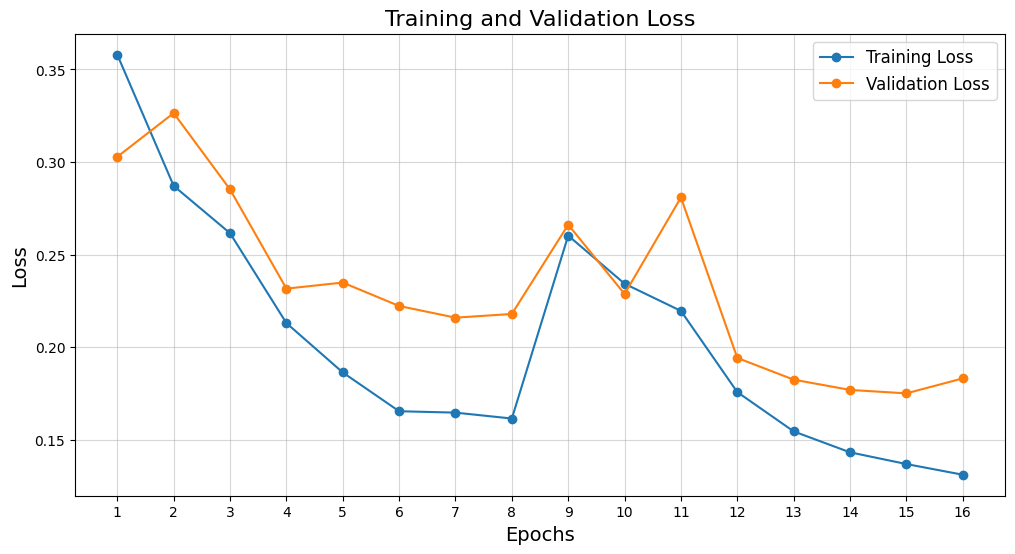

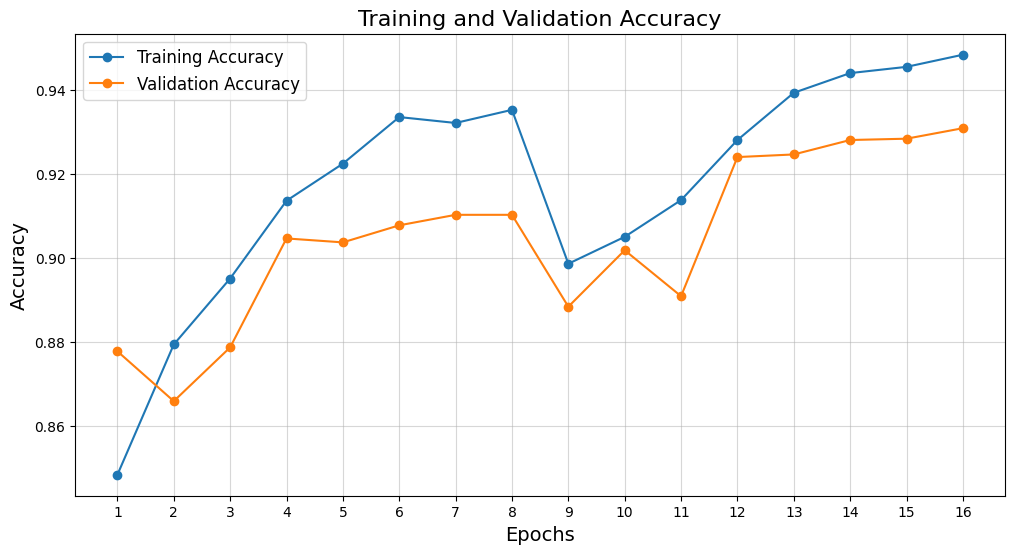

In [17]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(data["train_losses"]) + 1), data["train_losses"], label='Training Loss', marker='o')
plt.plot(range(1, len(data["val_losses"]) + 1), data["val_losses"], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(range(1, len(data["train_losses"]) + 1))
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(data["train_accuracies"]) + 1), data["train_accuracies"], label='Training Accuracy', marker='o')
plt.plot(range(1, len(data["val_accuracies"]) + 1), data["val_accuracies"], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(range(1, len(data["train_accuracies"]) + 1))
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()

In [18]:
ghgjgddfdf

NameError: name 'ghgjgddfdf' is not defined